In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install tensorflow opencv-python matplotlib


In [4]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation,
                                     GlobalAveragePooling2D, Reshape, Dense,
                                     AveragePooling2D, UpSampling2D, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (ModelCheckpoint, CSVLogger, ReduceLROnPlateau, 
                                        EarlyStopping, TensorBoard, LearningRateScheduler)
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Helper functions
def ASPP(x):
    pool = AveragePooling2D(pool_size=(x.shape[1], x.shape[2]))(x)
    y1 = UpSampling2D((x.shape[1], x.shape[2]), interpolation="bilinear")(
        Conv2D(256, 1, padding="same", use_bias=False)(BatchNormalization()(pool))
    )
    y2 = Conv2D(256, 1, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(Conv2D(256, 3, padding="same", dilation_rate=6)(x))
    y4 = BatchNormalization()(Conv2D(256, 3, padding="same", dilation_rate=12)(x))
    y5 = BatchNormalization()(Conv2D(256, 3, padding="same", dilation_rate=18)(x))
    return Conv2D(256, 1, padding="same", use_bias=False)(Concatenate()([y1, y2, y3, y4, y5]))

def deeplabv3_plus(input_shape):
    inputs = Input(shape=input_shape)
    encoder = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    x_a = ASPP(encoder.get_layer("conv4_block6_out").output)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    x_b = Activation('relu')(BatchNormalization()(
        Conv2D(48, 1, padding='same', use_bias=False)(encoder.get_layer("conv2_block2_out").output)
    ))

    x = Concatenate()([x_a, x_b])
    x = BatchNormalization()(
        Conv2D(256, 3, padding='same', use_bias=False)(Activation('relu')(x))
    )

    x = UpSampling2D((4, 4), interpolation="bilinear")(
        Conv2D(1, 1, padding='same')(x)
    )
    return Model(inputs, Activation("sigmoid")(x))

# Constants
H, W = 256, 256
BATCH_SIZE = 32
LR = 1e-4
NUM_EPOCHS = 10

# Dataset paths
DATASET_PATH = r'/kaggle/input/kits23-split-dataset'
train_slices = os.path.join(DATASET_PATH, "split_data", "train", "slices")
train_masks = os.path.join(DATASET_PATH, "split_data", "train", "masks")
val_slices = os.path.join(DATASET_PATH, "split_data", "val", "slices")
val_masks = os.path.join(DATASET_PATH, "split_data", "val", "masks")

train_x = sorted([os.path.join(train_slices, img) for img in os.listdir(train_slices)])
train_y = sorted([os.path.join(train_masks, mask) for mask in os.listdir(train_masks)])
valid_x = sorted([os.path.join(val_slices, img) for img in os.listdir(val_slices)])
valid_y = sorted([os.path.join(val_masks, mask) for mask in os.listdir(val_masks)])

print(f"Training samples: {len(train_x)}, Validation samples: {len(valid_x)}")

# Data Augmentation
def augment(x, y):
    if random.random() > 0.5:
        x = tf.image.flip_left_right(x)
        y = tf.image.flip_left_right(y)
    if random.random() > 0.5:
        x = tf.image.flip_up_down(x)
        y = tf.image.flip_up_down(y)
    if random.random() > 0.5:
        x = tf.image.rot90(x)
        y = tf.image.rot90(y)
    return x, y

# Preprocessing
def tf_parse(x, y):
    x = tf.io.read_file(x)
    x = tf.image.decode_jpeg(x, channels=3)
    y = tf.io.read_file(y)
    y = tf.image.decode_jpeg(y, channels=1)
    x = tf.image.resize(x, [H, W]) / 255.0
    y = tf.image.resize(y, [H, W]) / 255.0 # Ensure masks are resized correctly
    return x, y

def tf_dataset(X, Y, batch=BATCH_SIZE, augment_data=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.batch(batch).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = tf_dataset(train_x, train_y, augment_data=True)
valid_dataset = tf_dataset(valid_x, valid_y)

smooth = 1.0
def dice_coef(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true > 0.5, tf.float32)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return dice + bce

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

opt = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)

# Model Compilation
model = deeplabv3_plus((H, W, 3))
model.compile(
    loss=bce_dice_loss,
    optimizer=opt,
    metrics=[dice_coef, iou, Recall(name='recall'), Precision(name='precision'), "accuracy"]
)

def lr_schedule(epoch, lr):
    if epoch > 30:
        return lr * 0.5
    return lr

callbacks = [
    ModelCheckpoint(os.path.join(DATASET_PATH, 'checkpoints', 'model_best.keras'), 
                    monitor='val_dice_coef', mode='max', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    LearningRateScheduler(lr_schedule),
    CSVLogger('training_log.csv'),
    TensorBoard(log_dir='logs')
]

# Training
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=NUM_EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if 'dice_coef' in metrics and 'val_dice_coef' in metrics:
        plt.subplot(2, 2, 2)
        plt.plot(epochs_range, history.history['dice_coef'], label='Training Dice Coefficient')
        plt.plot(epochs_range, history.history['val_dice_coef'], label='Validation Dice Coefficient')
        plt.title('Training and Validation Dice Coefficient')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Coefficient')
        plt.legend()

    if 'iou' in metrics and 'val_iou' in metrics:
        plt.subplot(2, 2, 3)
        plt.plot(epochs_range, history.history['iou'], label='Training IoU')
        plt.plot(epochs_range, history.history['val_iou'], label='Validation IoU')
        plt.title('Training and Validation IoU')
        plt.xlabel('Epochs')
        plt.ylabel('IoU')
        plt.legend()

    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300)
    plt.show()

plot_training_history(history)


Training samples: 5471, Validation samples: 1172
Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6246 - dice_coef: 0.1008 - iou: 0.0169 - loss: 1.5968 - precision: 0.0544 - recall: 0.8874   

OSError: [Errno 30] Read-only file system: '/kaggle/input/kits23-split-dataset/checkpoints'

Training samples: 5471, Validation samples: 1172
Epoch 1/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.7126 - dice_coef: 0.1763 - iou: 0.0181 - loss: 1.4663 - precision: 0.0769 - recall: 0.8848
Epoch 1: val_dice_coef improved from -inf to 0.00006, saving model to /kaggle/working/checkpoints/model_best.keras
342/342 ━━━━━━━━━━━━━━━━━━━━ 271s 558ms/step - accuracy: 0.7130 - dice_coef: 0.1768 - iou: 0.0181 - loss: 1.4655 - precision: 0.0770 - recall: 0.8847 - val_accuracy: 0.9769 - val_dice_coef: 6.2227e-05 - val_iou: 0.0117 - val_loss: 1.3675 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9767 - dice_coef: 0.6821 - iou: 0.0278 - loss: 0.6552 - precision: 0.7933 - recall: 0.7345
Epoch 2: val_dice_coef improved from 0.00006 to 0.00149, saving model to /kaggle/working/checkpoints/model_best.keras
342/342 ━━━━━━━━━━━━━━━━━━━━ 120s 350ms/step - accuracy: 0.9767 - dice_coef: 0.68

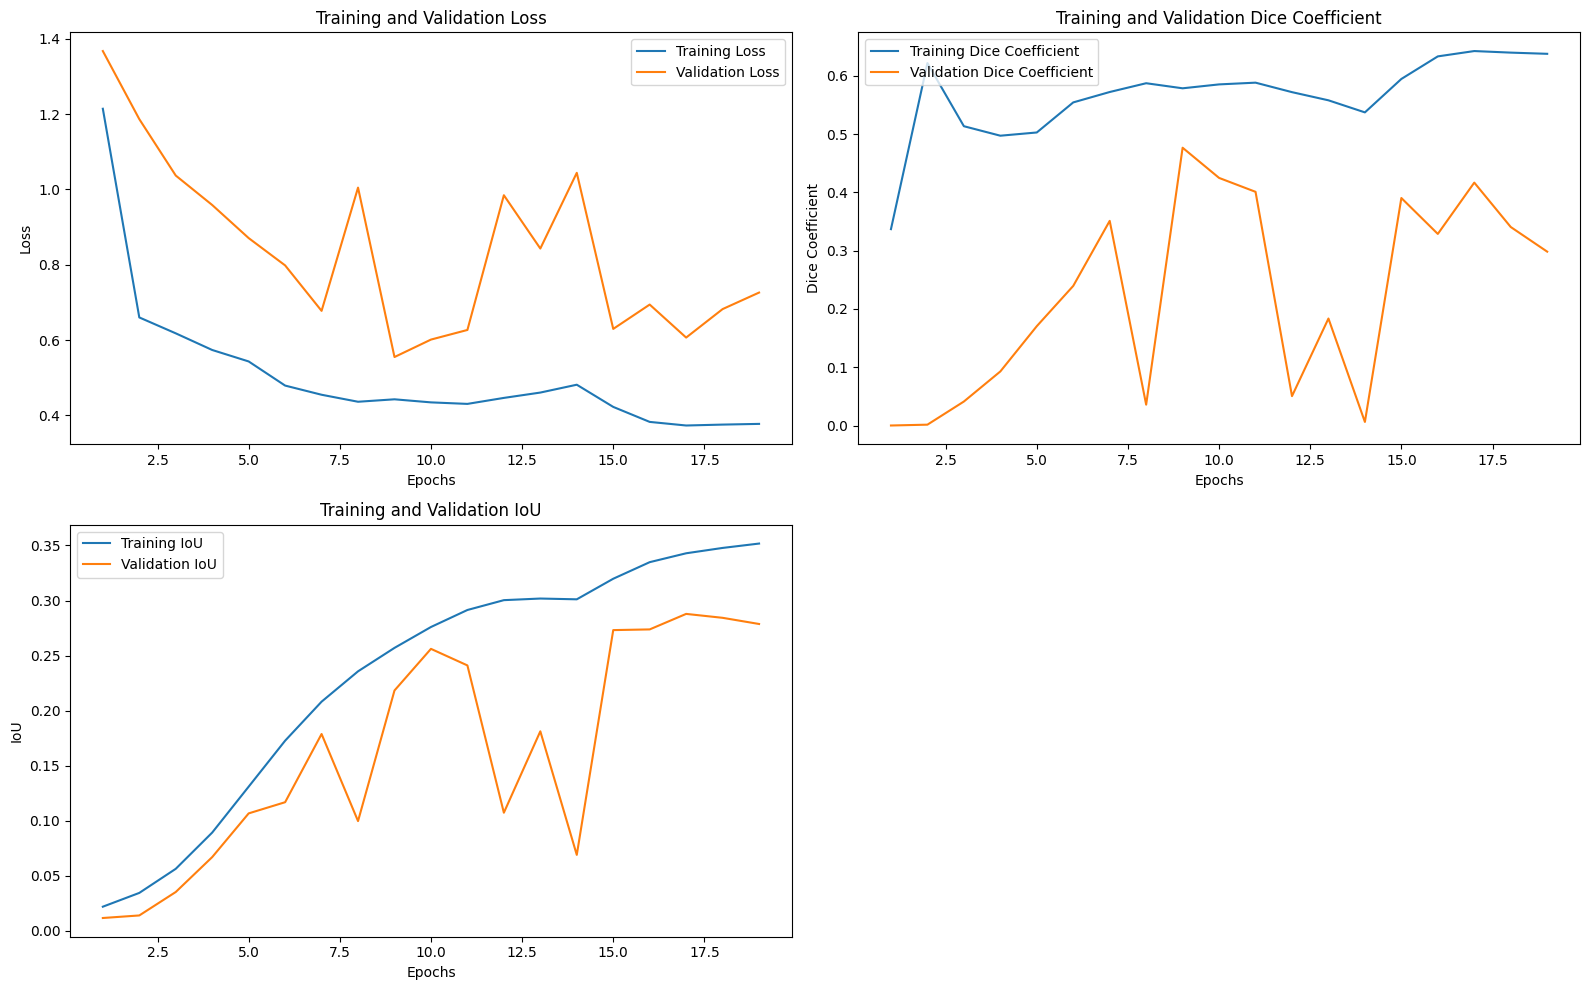

In [6]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation,
                                     GlobalAveragePooling2D, Reshape, Dense,
                                     AveragePooling2D, UpSampling2D, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (ModelCheckpoint, CSVLogger, ReduceLROnPlateau, 
                                        EarlyStopping, TensorBoard, LearningRateScheduler)
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Helper functions
def ASPP(x):
    pool = AveragePooling2D(pool_size=(x.shape[1], x.shape[2]))(x)
    y1 = UpSampling2D((x.shape[1], x.shape[2]), interpolation="bilinear")(
        Conv2D(256, 1, padding="same", use_bias=False)(BatchNormalization()(pool))
    )
    y2 = Conv2D(256, 1, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(Conv2D(256, 3, padding="same", dilation_rate=6)(x))
    y4 = BatchNormalization()(Conv2D(256, 3, padding="same", dilation_rate=12)(x))
    y5 = BatchNormalization()(Conv2D(256, 3, padding="same", dilation_rate=18)(x))
    return Conv2D(256, 1, padding="same", use_bias=False)(Concatenate()([y1, y2, y3, y4, y5]))

def deeplabv3_plus(input_shape):
    inputs = Input(shape=input_shape)
    encoder = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    x_a = ASPP(encoder.get_layer("conv4_block6_out").output)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    x_b = Activation('relu')(BatchNormalization()(
        Conv2D(48, 1, padding='same', use_bias=False)(encoder.get_layer("conv2_block2_out").output)
    ))

    x = Concatenate()([x_a, x_b])
    x = BatchNormalization()(
        Conv2D(256, 3, padding='same', use_bias=False)(Activation('relu')(x))
    )

    x = UpSampling2D((4, 4), interpolation="bilinear")(
        Conv2D(1, 1, padding='same')(x)
    )
    return Model(inputs, Activation("sigmoid")(x))

# Constants
H, W = 256, 256
BATCH_SIZE = 16
LR = 1e-4
NUM_EPOCHS = 25

# Dataset paths
DATASET_PATH = r'/kaggle/input/kits23-split-dataset'
train_slices = os.path.join(DATASET_PATH, "split_data", "train", "slices")
train_masks = os.path.join(DATASET_PATH, "split_data", "train", "masks")
val_slices = os.path.join(DATASET_PATH, "split_data", "val", "slices")
val_masks = os.path.join(DATASET_PATH, "split_data", "val", "masks")

train_x = sorted([os.path.join(train_slices, img) for img in os.listdir(train_slices)])
train_y = sorted([os.path.join(train_masks, mask) for mask in os.listdir(train_masks)])
valid_x = sorted([os.path.join(val_slices, img) for img in os.listdir(val_slices)])
valid_y = sorted([os.path.join(val_masks, mask) for mask in os.listdir(val_masks)])

print(f"Training samples: {len(train_x)}, Validation samples: {len(valid_x)}")

# Data Augmentation
def augment(x, y):
    if random.random() > 0.5:
        x = tf.image.flip_left_right(x)
        y = tf.image.flip_left_right(y)
    if random.random() > 0.5:
        x = tf.image.flip_up_down(x)
        y = tf.image.flip_up_down(y)
    if random.random() > 0.5:
        x = tf.image.rot90(x)
        y = tf.image.rot90(y)
    return x, y

# Preprocessing
def tf_parse(x, y):
    x = tf.io.read_file(x)
    x = tf.image.decode_jpeg(x, channels=3)
    y = tf.io.read_file(y)
    y = tf.image.decode_jpeg(y, channels=1)
    x = tf.image.resize(x, [H, W]) / 255.0
    y = tf.image.resize(y, [H, W]) / 255.0 # Ensure masks are resized correctly
    return x, y

def tf_dataset(X, Y, batch=BATCH_SIZE, augment_data=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.batch(batch).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = tf_dataset(train_x, train_y, augment_data=True)
valid_dataset = tf_dataset(valid_x, valid_y)

smooth = 1.0
def dice_coef(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true > 0.5, tf.float32)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return dice + bce

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

opt = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)

# Model Compilation
model = deeplabv3_plus((H, W, 3))
model.compile(
    loss=bce_dice_loss,
    optimizer=opt,
    metrics=[dice_coef, iou, Recall(name='recall'), Precision(name='precision'), "accuracy"]
)

# Ensure checkpoint directory exists
os.makedirs('/kaggle/working/checkpoints', exist_ok=True)

def lr_schedule(epoch, lr):
    if epoch > 30:
        return lr * 0.5
    return lr

callbacks = [
    ModelCheckpoint('/kaggle/working/checkpoints/model_best.keras', 
                    monitor='val_dice_coef', mode='max', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    LearningRateScheduler(lr_schedule),
    CSVLogger('/kaggle/working/training_log.csv'),
    TensorBoard(log_dir='/kaggle/working/logs')
]

# Training
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=NUM_EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if 'dice_coef' in metrics and 'val_dice_coef' in metrics:
        plt.subplot(2, 2, 2)
        plt.plot(epochs_range, history.history['dice_coef'], label='Training Dice Coefficient')
        plt.plot(epochs_range, history.history['val_dice_coef'], label='Validation Dice Coefficient')
        plt.title('Training and Validation Dice Coefficient')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Coefficient')
        plt.legend()

    if 'iou' in metrics and 'val_iou' in metrics:
        plt.subplot(2, 2, 3)
        plt.plot(epochs_range, history.history['iou'], label='Training IoU')
        plt.plot(epochs_range, history.history['val_iou'], label='Validation IoU')
        plt.title('Training and Validation IoU')
        plt.xlabel('Epochs')
        plt.ylabel('IoU')
        plt.legend()

    plt.tight_layout()
    plt.savefig('/kaggle/working/training_metrics.png', dpi=300)
    plt.show()

plot_training_history(history)
